In [99]:
import sys
sys.dont_write_bytecode = True
import time
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate
import qutip as qt
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
from Fluxonium_hamiltonians import qchard_fluxonium as fluxonium
from Fluxonium_hamiltonians import qchard_coupobj as coupobj
from Fluxonium_hamiltonians import qchard_evolgates as evolgates
from Fluxonium_hamiltonians import qchard_resonator as resonator
import plotting_settings
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 400
plt.close('all')

In [116]:
# Parameters from notebook 2e. Multipath coupling. 
#Energies are in GHz

E_L1 = 1
E_C1 = 1
E_J1 = 4

E_L2 = 0.8
E_C2 = 1
E_J2 = 4*(E_L2/E_L1)

J_C = 0.001
phi_ext_A = np.pi
phi_ext_B = np.pi

omega_c = 7 
g = 0.3

# Gate parameters.
T_gate = 100
# Pulse shape.
shape = 'square'  # 'gauss', 'cos' for 1-cos, or 'square'
sigma = 0.25  # sigma in units of T_gate for shape=='gauss'
drag = False
drag_coeff = 0.2

# Scaling of the ideal value given by the inverse matrix element.
drive_amplitude_factor = 1  # 0.95436
# Drive frequency with respect to the resonance.
delta_omega_d = 0

# Method to calculate the propagator.
# 'propagator - full propagator using qt.propagator
# 'sesolve' - propagator using qt.sesolve for 4 computational states
method = 'propagator'

# Hilbert space.
nlev_cav = 3
nlev_q = 5

save_figure = False
filename_prefix = 'stuff'

# Indices of the computational space.
comp_space = ['00', '01', '10', '11']
interaction = 'on'

# Transitions to show
states11 = ['11', '21', '22']
states10 = ['10', '20']
states01 = ['01', '02']
states00 = ['00','10','01']

# Instantiate objects
qubitA = fluxonium.Fluxonium(
    E_L=E_L1, E_C=E_C1, E_J=E_J1, nlev=nlev_q, phi_ext = phi_ext_A)
qubitB = fluxonium.Fluxonium(
    E_L=E_L2, E_C=E_C2, E_J=E_J2, nlev=nlev_q, phi_ext = phi_ext_B)
coupl_res = resonator.Cavity(omega=omega_c, nlev=nlev_cav)
# system = coupobj.CoupledObjects(qubitA, qubitB, coupl_res,
#                                     [qubitA, qubitB, J_C, 'charge'],
#                                     [coupl_res, qubitA, g, 'JC-charge'],
#                                     [coupl_res, qubitB, g, 'JC-charge'])

#test
system = coupobj.CoupledObjects(qubitA, qubitB,
                                    [qubitA, qubitB, J_C, 'flux'])

In [119]:
## Here, check the drive amplitude wrt qubit A
# Calculate the drive frequency.
transition_to_drive = ('00', '10')
level1, level2 = transition_to_drive[0], transition_to_drive[1]
delta_omega_d = 0
omega_d = abs(system.freq(level1, level2)) + delta_omega_d
print(omega_d)

# Calculate the drive amplitude.
matr_el = np.abs(system.n_ij(qubitA, level1, level2)
                 + 0*system.n_ij(qubitB, level1, level2))
epsilon = drive_amplitude_factor / abs(matr_el)

t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)

# The time-independent operator part of the drive term.
H_drive = epsilon * (system.n(0) + 0*system.n(1))

if method == 'sesolve':
    # This calculates the evolution operator that works for
    # computational levels only.
    U_t = evolgates.evolution_compspace_microwave(system.H(), H_drive, comp_space=comp_space, t_points=t_points,T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d,interaction=interaction)

elif method == 'propagator':
    # This calculates the evolution operator for the whole system  
    U_t = evolgates.evolution_operator_microwave(system.H(), H_drive, comp_space=comp_space, t_points=t_points,T_gate=T_gate, shape=shape, sigma=sigma, DRAG = drag, DRAG_coefficient = drag_coeff, omega_d=omega_d,interaction=interaction)

0.5815936520108833


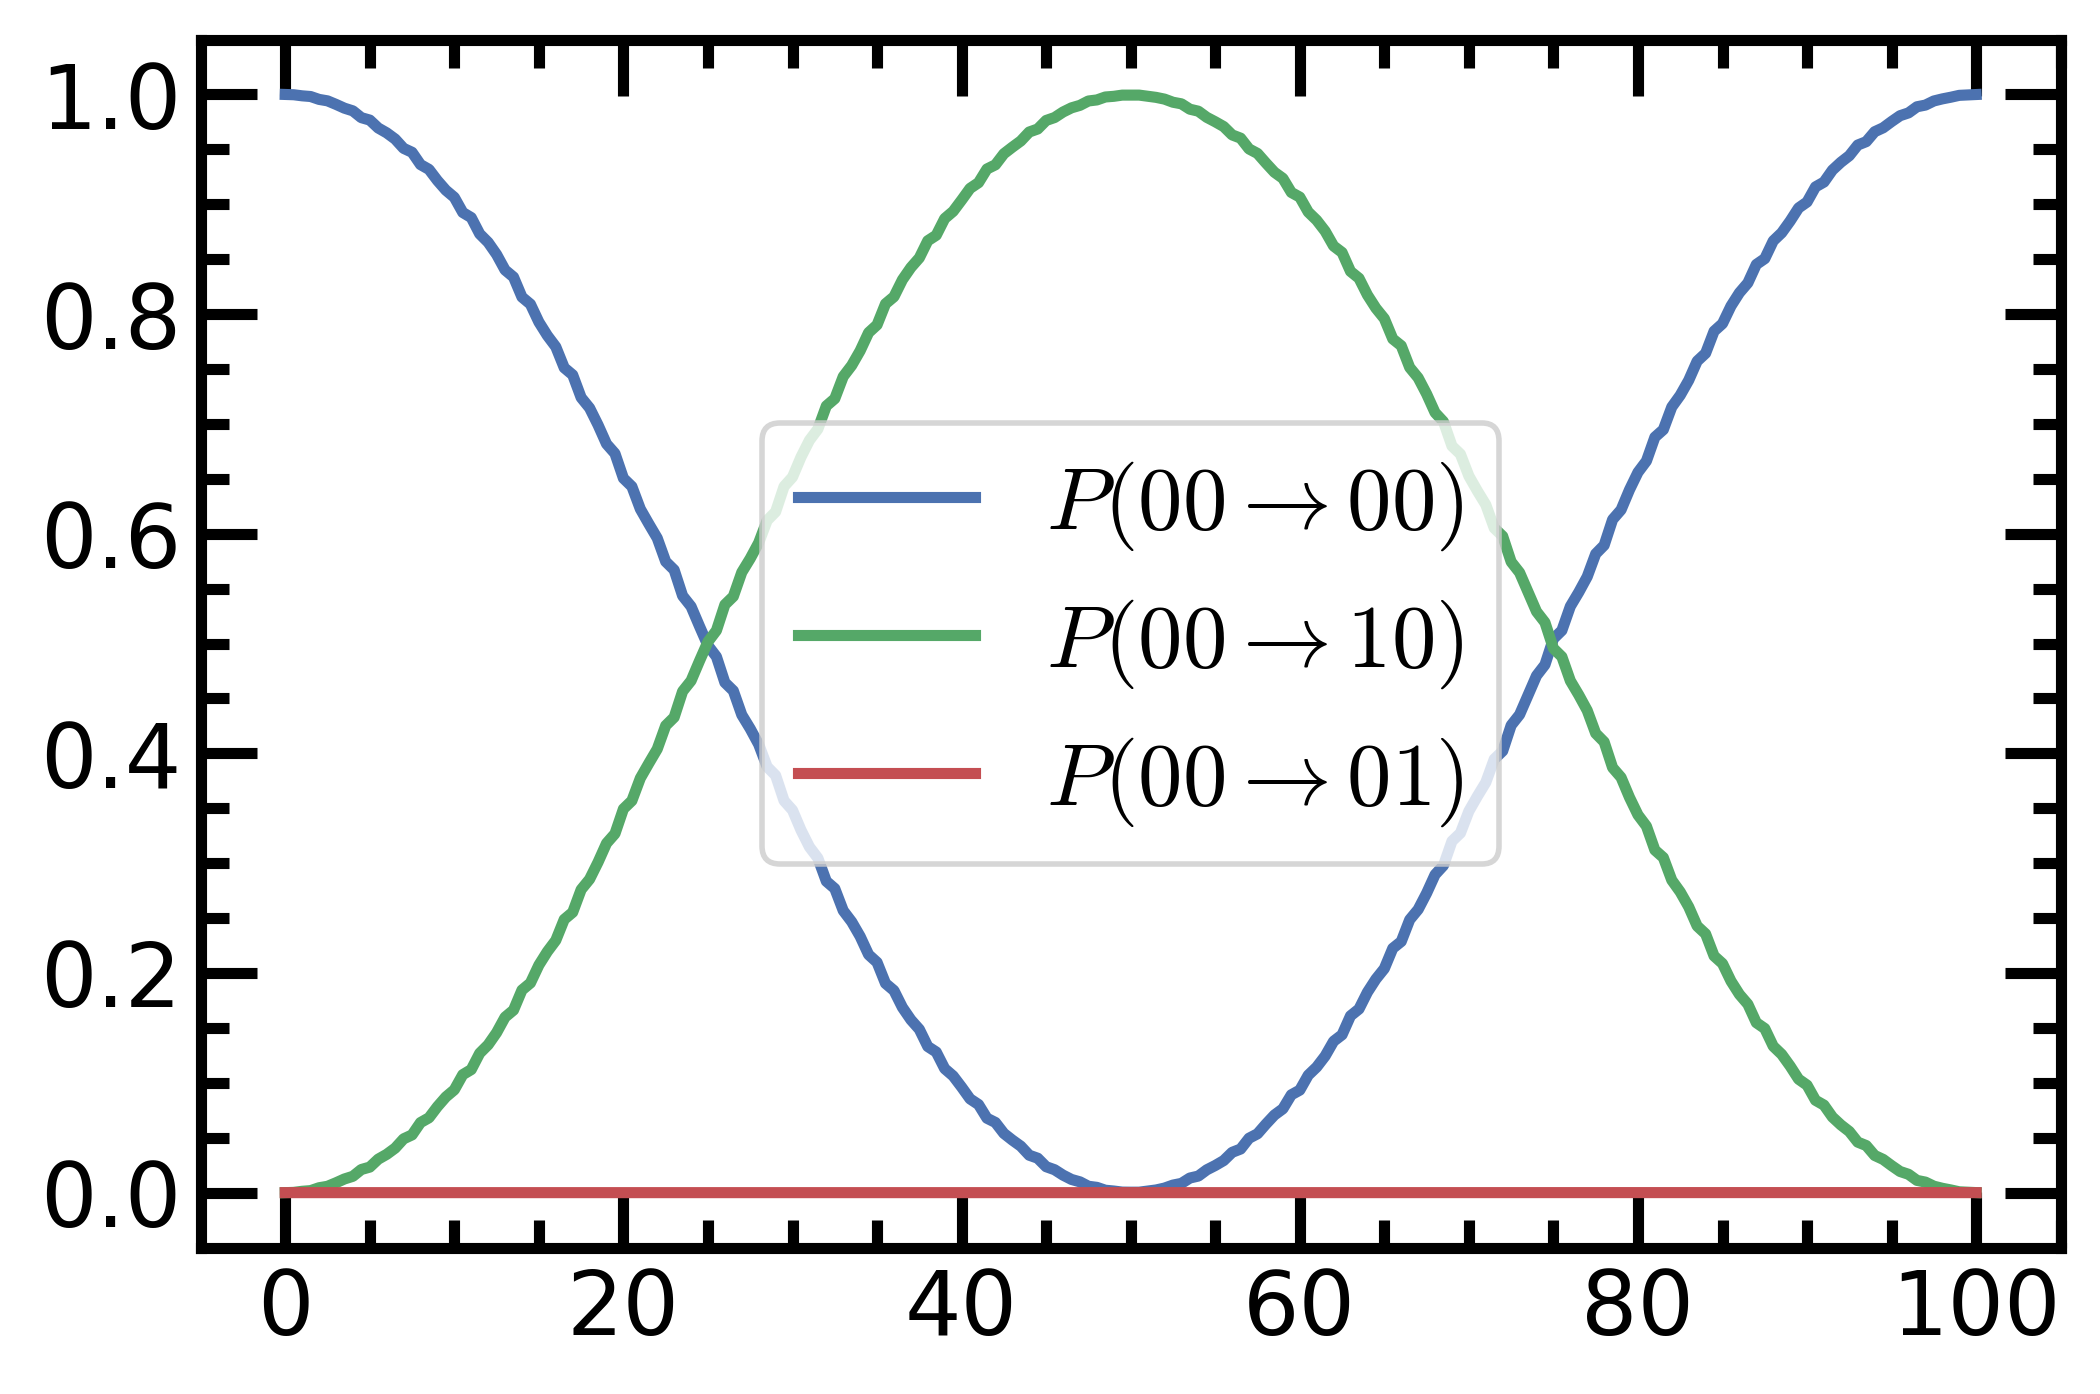

In [120]:
P00 = {}
for state in states00:
    P00[state] = evolgates.prob_transition(U_t, system.eigvec('00'), system.eigvec(state))
    plt.plot(t_points, P00[state], lw=2,
               label=r'$P(00\rightarrow {})$'.format(state))
plt.legend()

In [121]:
#Here, check the drive amplitude wrt qubit B
# Calculate the drive frequency.
T_gate = 100
transition_to_drive = ('00', '01')
level1, level2 = transition_to_drive[0], transition_to_drive[1]
delta_omega_d = 0
omega_d = abs(system.freq(level1, level2)) + delta_omega_d
print(omega_d)

# Calculate the drive amplitude.
matr_el = np.abs(0*system.n_ij(qubitA, level1, level2)
                 + system.n_ij(qubitB, level1, level2))
epsilon = drive_amplitude_factor / abs(matr_el)

t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)

# The time-independent operator part of the drive term.
H_drive = epsilon * (0*system.n(0) + system.n(1))

if method == 'sesolve':
    # This calculates the evolution operator that works for
    # computational levels only.
    U_t = evolgates.evolution_compspace_microwave(system.H(), H_drive, comp_space=comp_space, t_points=t_points,T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d,interaction=interaction)

elif method == 'propagator':
    # This calculates the evolution operator for the whole system  
    U_t = evolgates.evolution_operator_microwave(system.H(), H_drive, comp_space=comp_space, t_points=t_points,T_gate=T_gate, shape=shape, sigma=sigma, DRAG = drag, DRAG_coefficient = drag_coeff, omega_d=omega_d,interaction=interaction)

0.6609431321865902


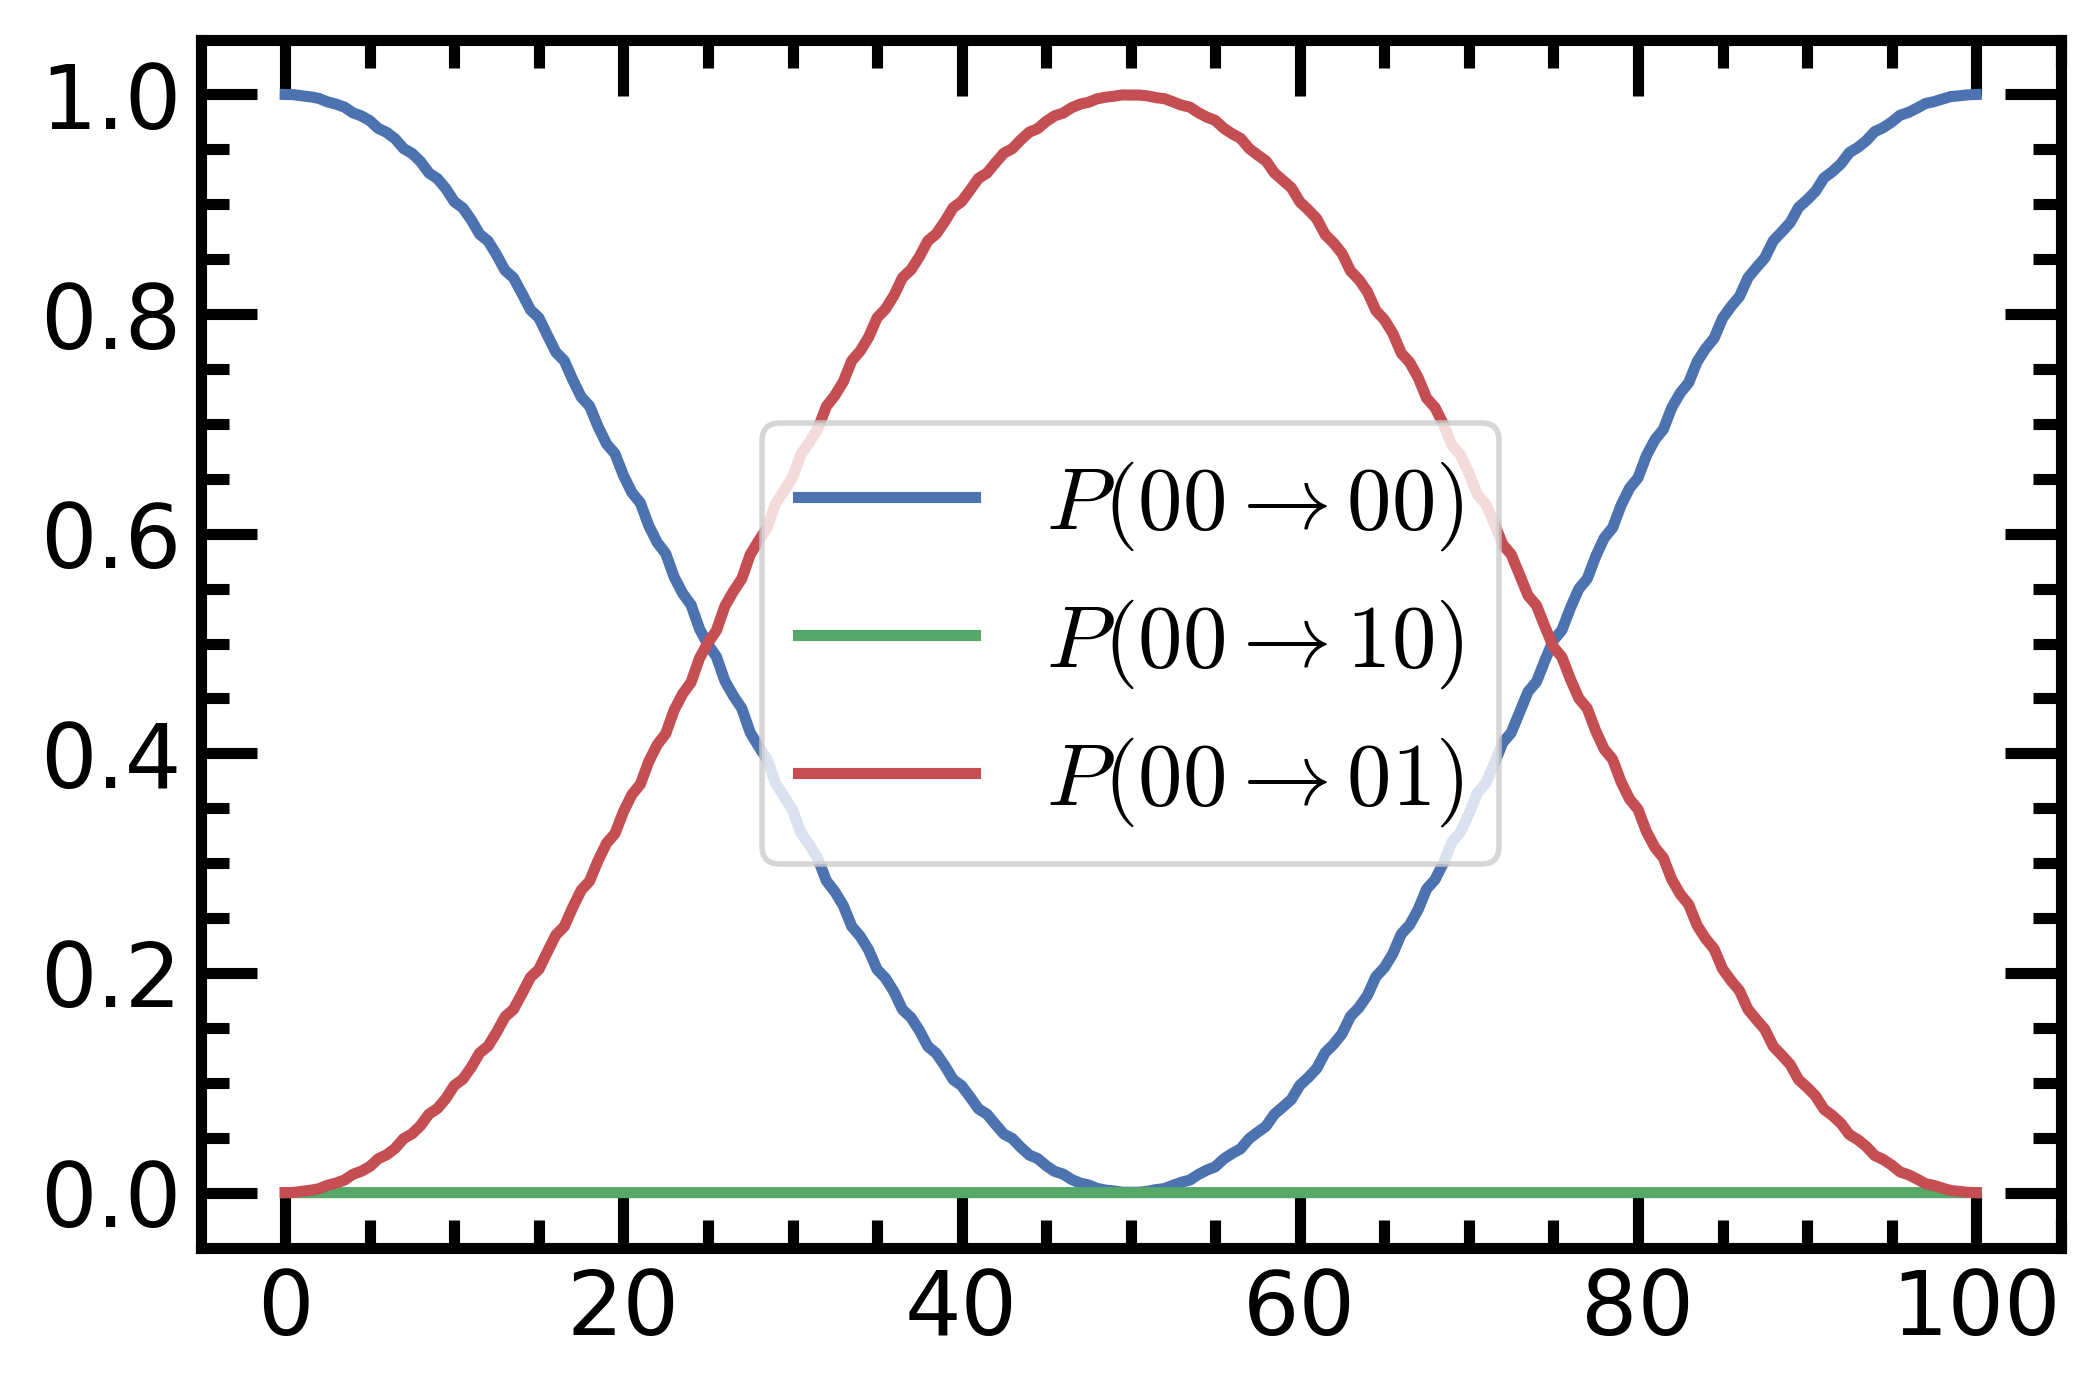

In [122]:
P00 = {}
for state in states00:
    P00[state] = evolgates.prob_transition(U_t, system.eigvec('00'), system.eigvec(state))
    plt.plot(t_points, P00[state], lw=2,
               label=r'$P(00\rightarrow {})$'.format(state))
plt.legend()

In [134]:
vec00 = system.eigvec('00')
vec01 = system.eigvec('01')
vec10 = system.eigvec('10')
vec11 = system.eigvec('11')

T_gate = 100
t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)

# Pulse shape.
shape = 'square'  # 'gauss', 'cos' for 1-cos, or 'square'
sigma = 0.25  # sigma in units of T_gate for shape=='gauss'
drag = False
drag_coeff = 0.2

# Calculate relative factor between matrix element to compensate for drive
transition_to_drive = ('00', '10', '01')
level1, level2, level3 = transition_to_drive[0], transition_to_drive[1], transition_to_drive[2]

matr_el = np.abs(system.n_ij(qubitA, level1, level2)
                 + 0*system.n_ij(qubitB, level1, level3))
eta = abs((system.n_ij(qubitA, level1, level2) / system.n_ij(qubitB, level1, level3)))
# print (abs(system.n_ij(qubitA, level1, level2)))
# print (abs(system.n_ij(qubitB, level1, level3)))
print (eta)

rabi_amp = 0.05 #GHz
coupl_const = rabi_amp*1e2
epsilon = coupl_const / abs(matr_el)
H_drive = 2*epsilon*(system.n(0) + eta*system.n(1)) #Two drives at the same time
    
drive_freq_array = np.linspace(0.5,0.8,61)
phase_evol = np.zeros((len(t_points), len(drive_freq_array)))

for freq_idx, omega_d in enumerate(drive_freq_array):
    U_t = evolgates.evolution_operator_microwave(system.H(), H_drive, comp_space=comp_space, t_points=t_points,T_gate=T_gate, shape=shape, sigma=sigma, DRAG = drag, DRAG_coefficient = drag_coeff, omega_d=omega_d,interaction=interaction)
    for t_idx in range(len(t_points)):
        u00 = U_t[t_idx].matrix_element(vec00.dag(), vec00)
        u01 = U_t[t_idx].matrix_element(vec01.dag(), vec01)
        u10 = U_t[t_idx].matrix_element(vec10.dag(), vec10)
        u11 = U_t[t_idx].matrix_element(vec11.dag(), vec11)
        phase_evol[t_idx, freq_idx] = np.angle(u11 * u00 / (u10 * u01))

0.891932664417343


In [135]:
fname = '/Users/longnguyen/Documents/tmp'
np.save(fname+'_fluxonium_phaseZZ_TLS',phase_evol)

In [136]:
def linear_func(x,slope,offsetx, offsety):
    return slope*(x-offsetx)+offsety
from scipy.optimize import curve_fit
toFit = np.load(fname+'_fluxonium_phaseZZ.npy')

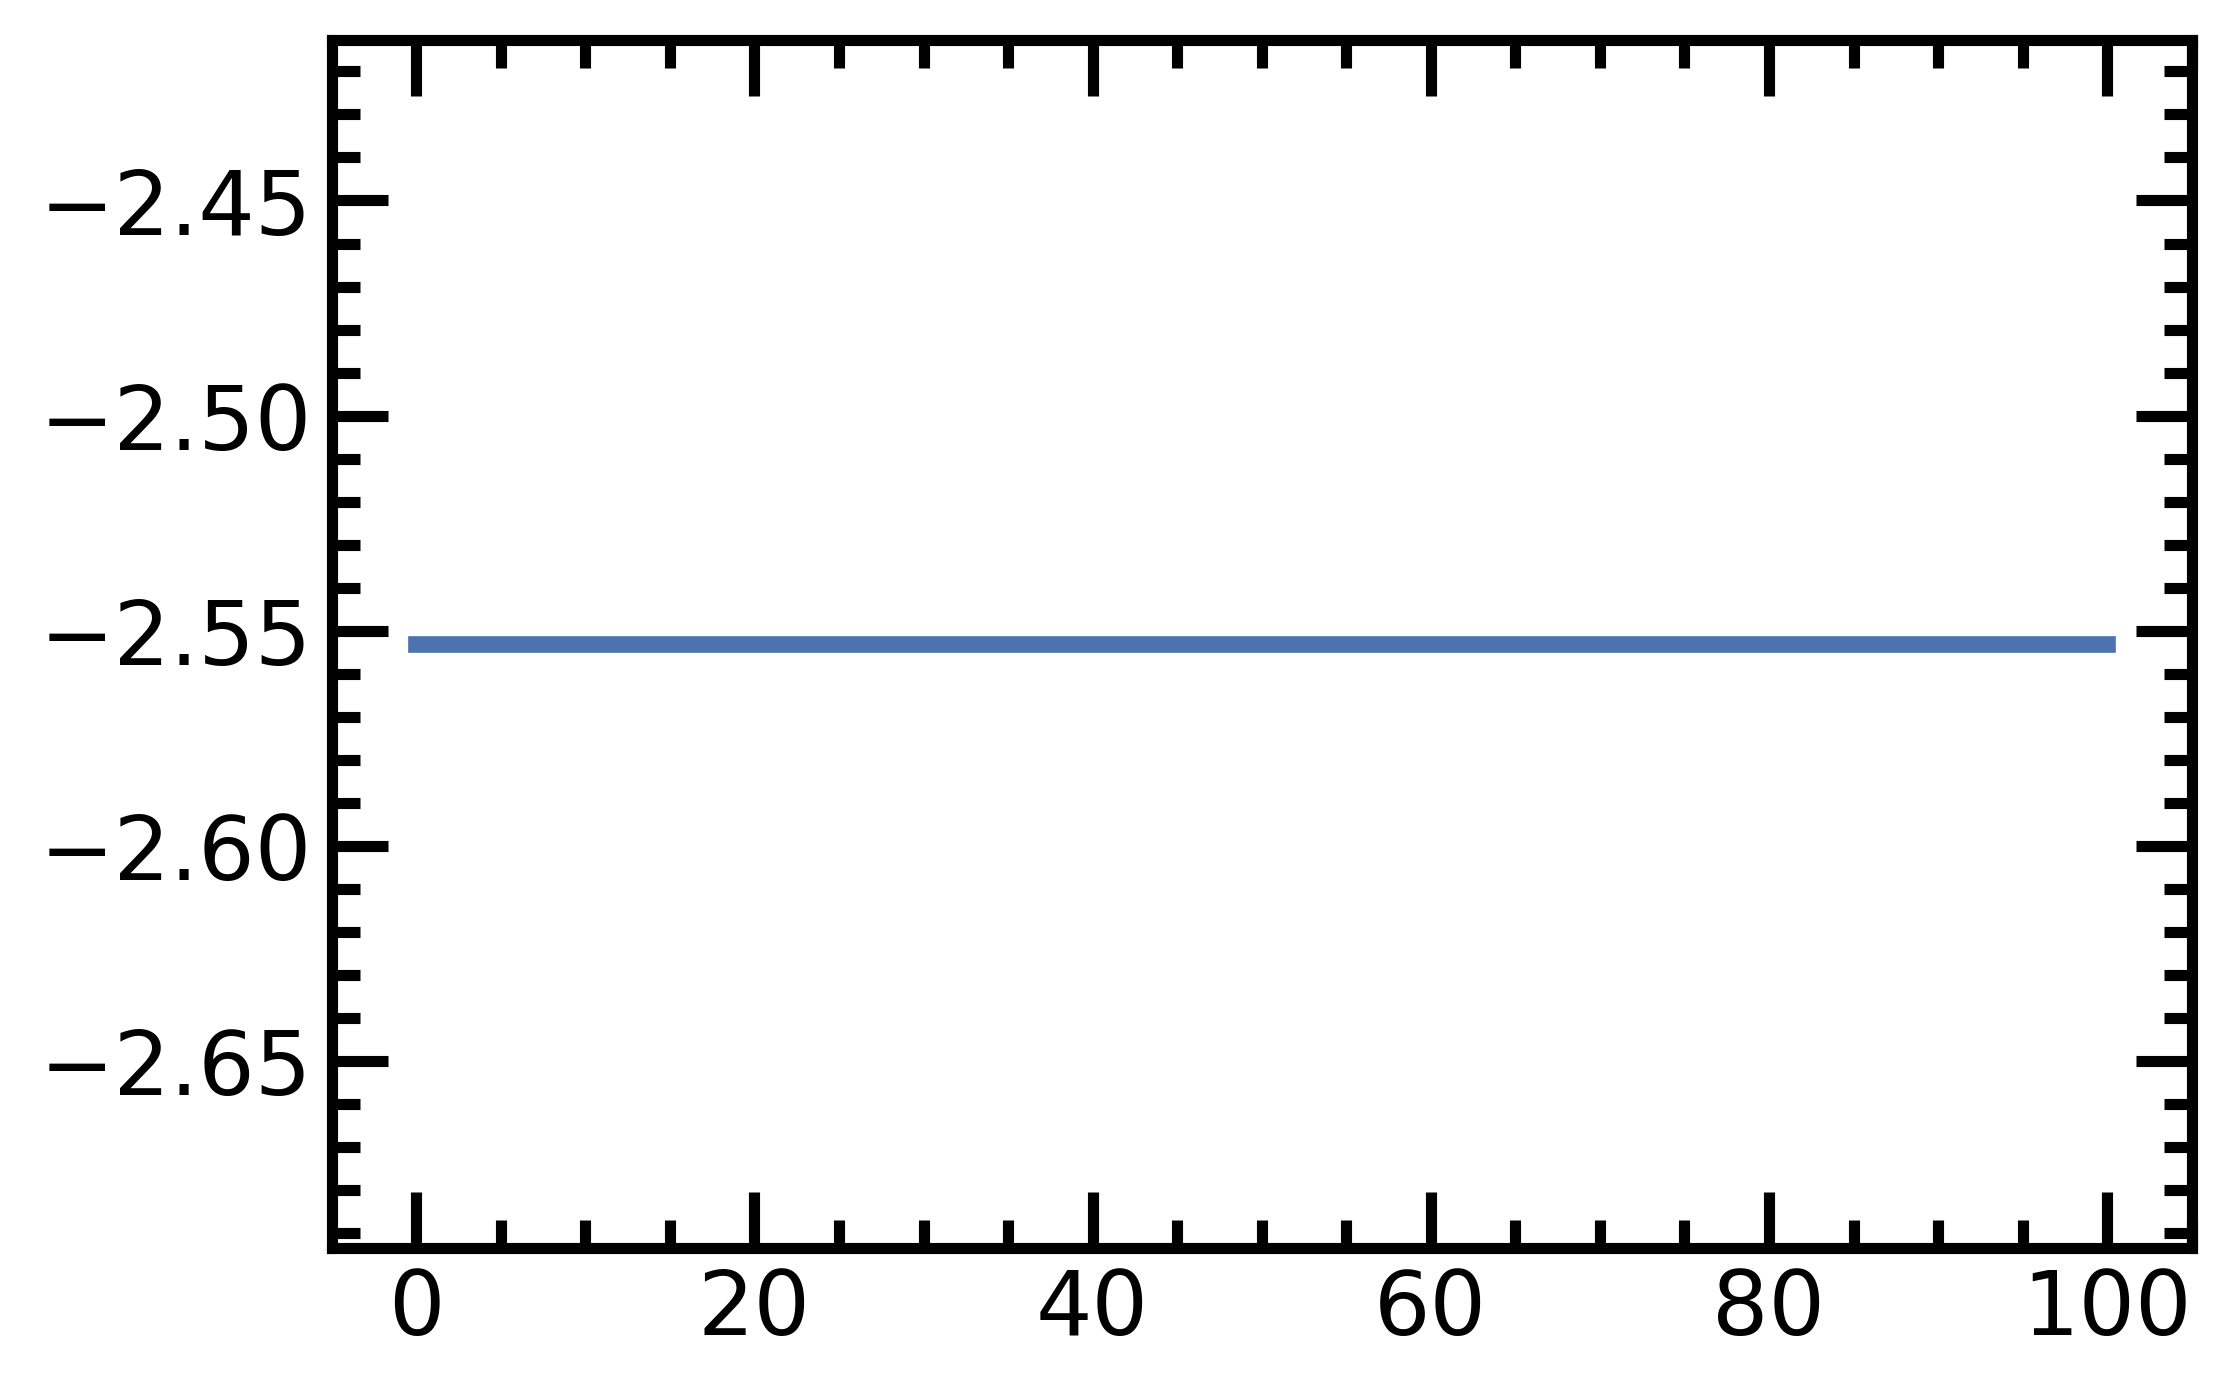

In [137]:
plt.plot (t_points, np.unwrap(toFit[:,0]))

In [138]:
ZZ_rate_hcf = np.zeros(len(drive_freq_array))
for w_idx in range(len(drive_freq_array)):
    phase = np.unwrap(toFit[:,w_idx])
#     slope_guess = (np.max(phase)-phase[0])/(t_points[np.argmax(phase)]-t_points[0])
    slope_guess = (phase[-1]-phase[0])/(t_points[-1]-t_points[0])
    guess = np.array([slope_guess,0,0])
    opt,cov = curve_fit(linear_func, ydata = phase, xdata = t_points, p0=guess)
    ZZ_rate_hcf[w_idx]= abs(opt[0])*1e3/(2*np.pi)
#     ZZ_rate_hcf[w_idx] = abs(slope_guess)*1e3/(2*np.pi)
        
plt.plot(drive_freq_array*1e3,  ZZ_rate_hcf, 's', label = 'MPC fluxoniums')
plt.ylabel(r'$|\zeta_{ZZ}|$ (MHz)')
plt.xlabel(r'$\omega_d$ (MHz)')
plt.title(r'$\Omega_A,\Omega_B=30$ (MHz)')
plt.legend()
plt.ylim(0,15)

<ipython-input-138-89480c7156c4>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  guess = np.array([slope_guess,0,0])


ValueError: operands could not be broadcast together with shapes (61,) (201,) 

In [123]:
# Sweep both amplitude and phase
rabi_amp_array = np.linspace(0,100,101)*1e-3 #GHz
coupl_const_array = rabi_amp_array * 1e2
drive_freq_array = np.linspace(0.5,0.8,61)
phase_evol = np.zeros((len(t_points), len(coupl_const_array), len(drive_freq_array)))
for amp_idx, coupl_const in enumerate(coupl_const_array):
    for freq_idx, omega_d in enumerate(drive_freq_array):
        epsilon = coupl_const / abs(matr_el)
        H_drive = 2*epsilon*(system.n(0) + eta*system.n(1))
        U_t = evolgates.evolution_operator_microwave(system.H(), H_drive, comp_space=comp_space, t_points=t_points,T_gate=T_gate, shape=shape, sigma=sigma, DRAG = drag, DRAG_coefficient = drag_coeff, omega_d=omega_d,interaction=interaction)
        for tind in range(len(t_points)):
            u00 = U_t[t_idx].matrix_element(vec00.dag(), vec00)
            u01 = U_t[t_idx].matrix_element(vec01.dag(), vec01)
            u10 = U_t[t_idx].matrix_element(vec10.dag(), vec10)
            u11 = U_t[t_idx].matrix_element(vec11.dag(), vec11)
            phase_evol[tind, amp_idx, freq_idx] = np.angle(u11 * u00 / (u10 * u01))

In [132]:
fname = '/Users/longnguyen/Documents/tmp'
np.save(fname+'_fluxonium_phaseZZ',phase_evol)

/Users/longnguyen/opt/anaconda3/envs/qutip-env/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


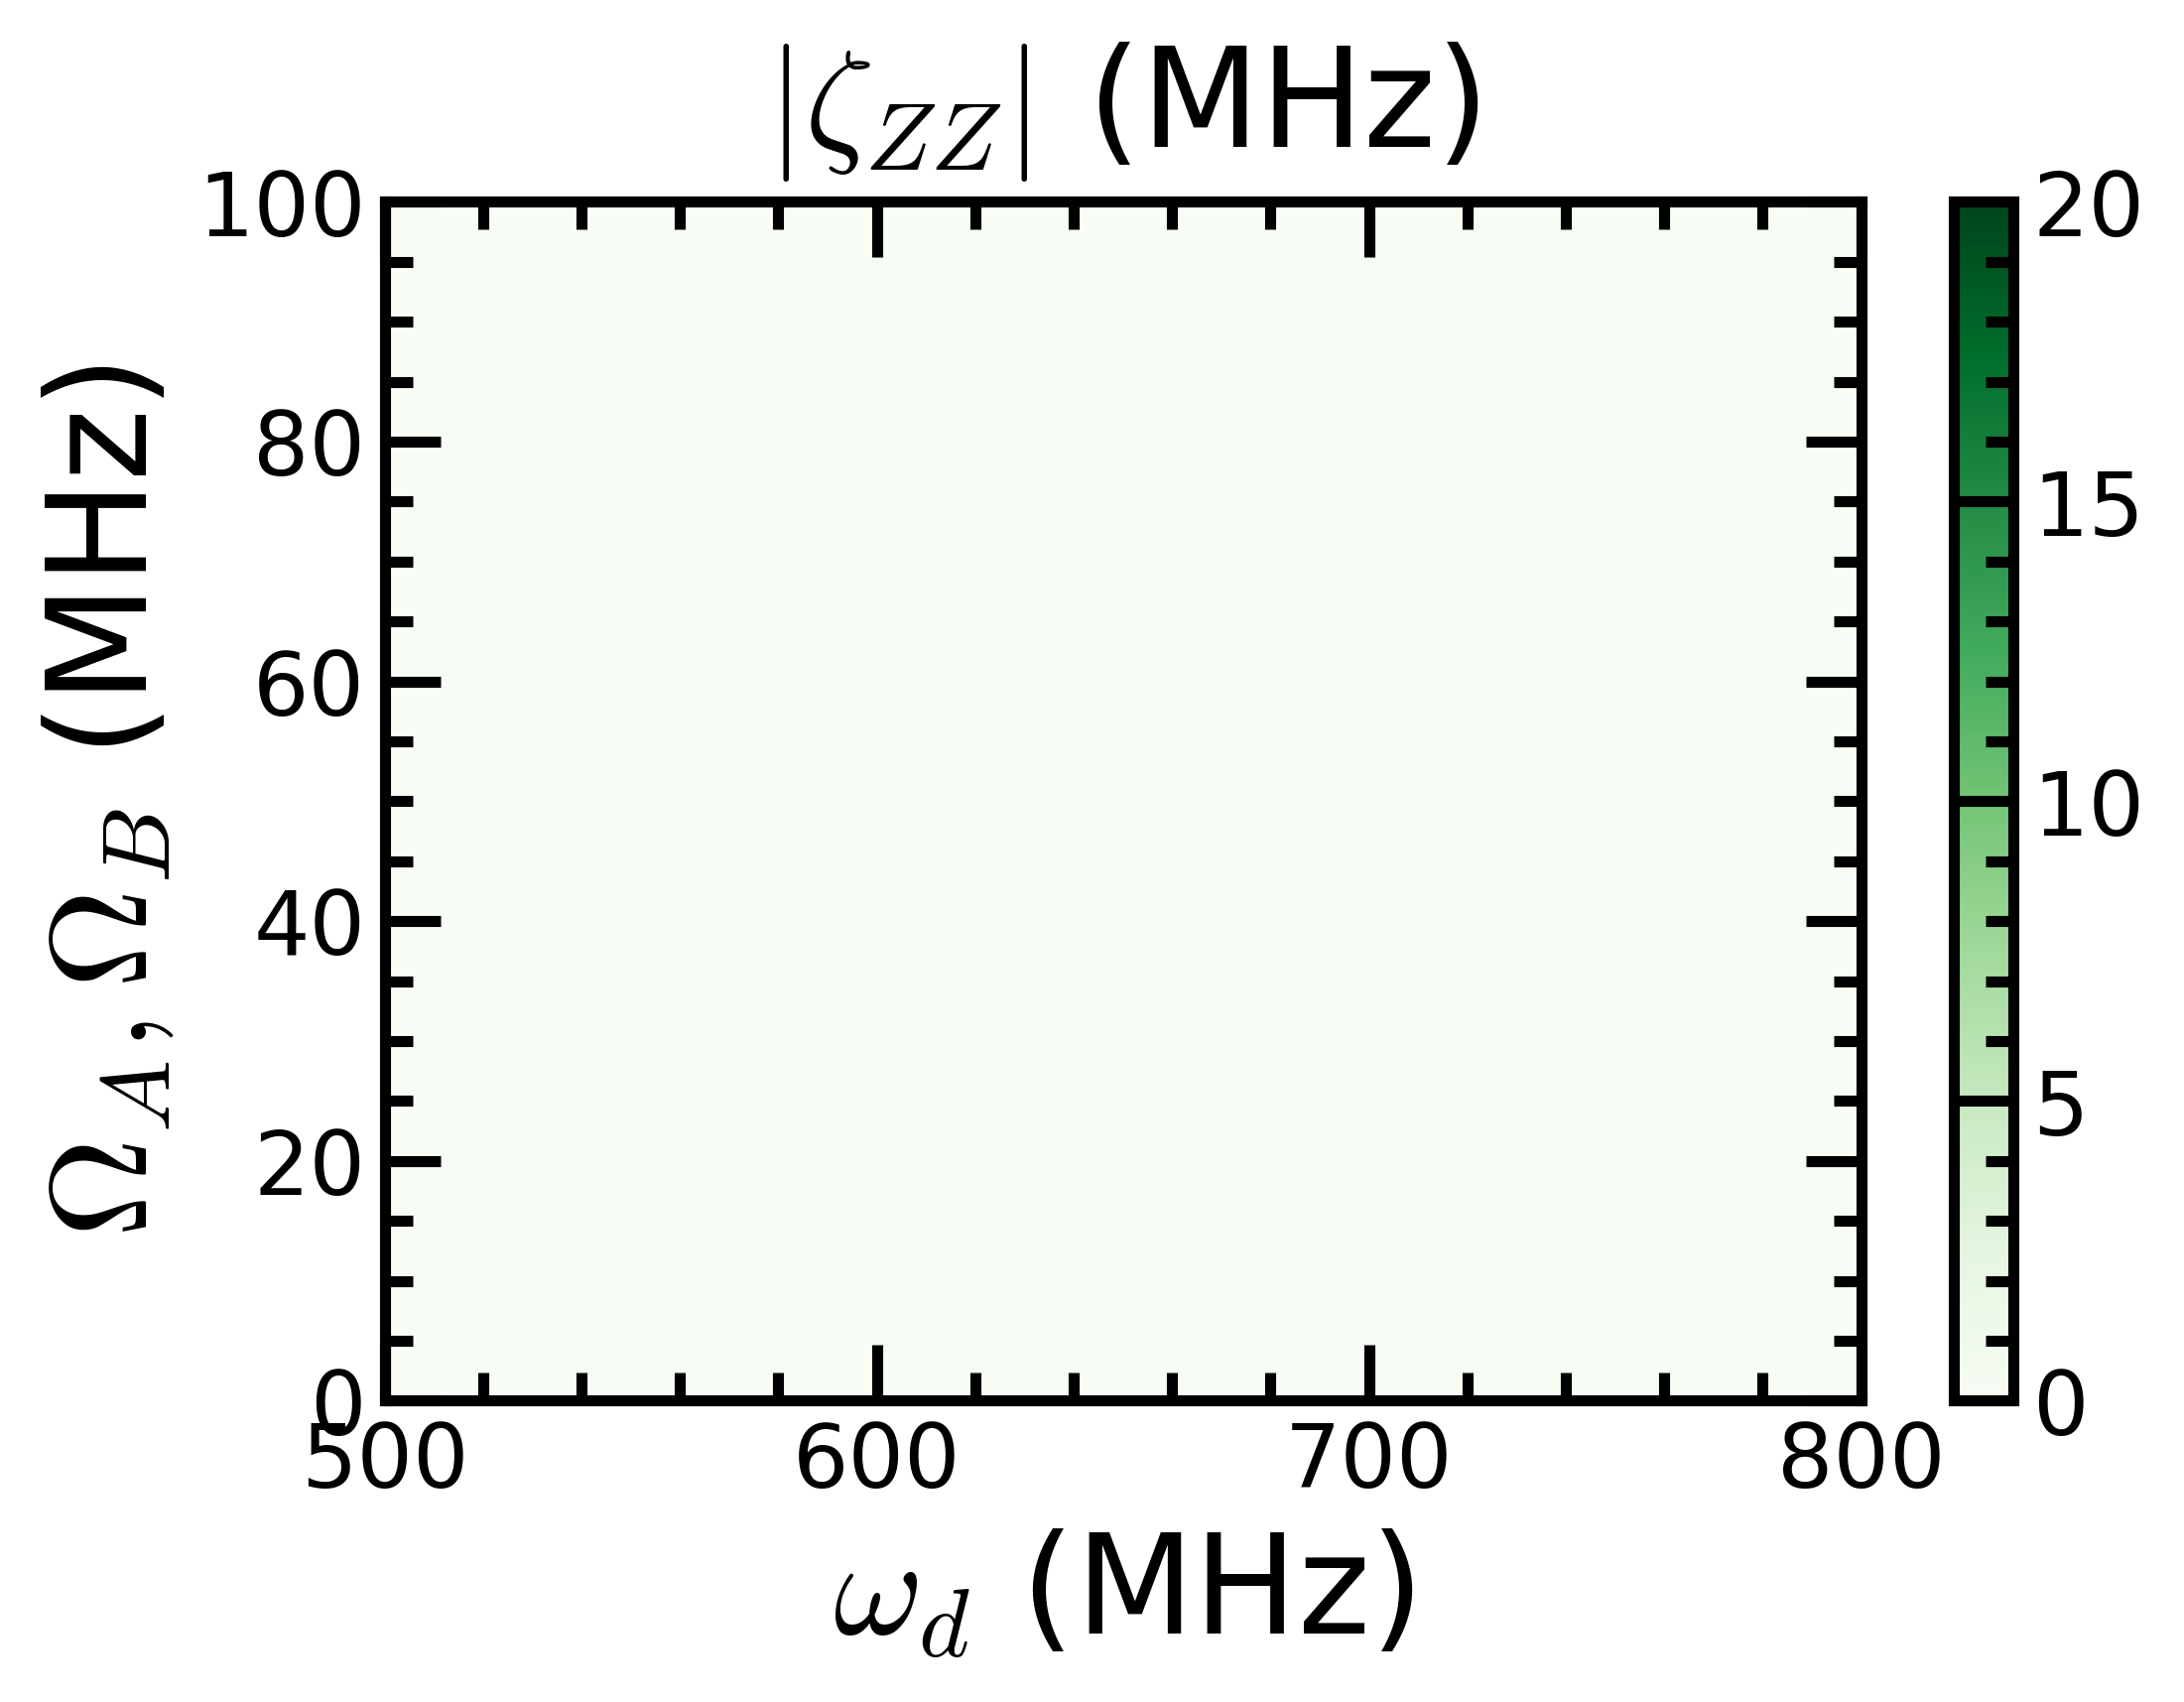

In [133]:
# toFit = np.load(fname+'_fluxonium_phaseZZ.npy')
toFit = phase_evol
ZZ_rate = np.zeros((len(coupl_const_array), len(drive_freq_array)))
for a_idx in range(len(coupl_const_array)):
    for w_idx in range(len(drive_freq_array)):
        phase = np.unwrap(toFit[:,a_idx,w_idx])
        slope_guess = (phase[-1]-phase[0])/(t_points[-1]-t_points[0])
        guess = np.array([slope_guess,0,0])
        opt,cov = curve_fit(linear_func, ydata = phase, xdata = t_points, p0=guess)
        ZZ_rate[a_idx,w_idx]= abs(opt[0])*1e3/(2*np.pi)
        
X,Y = np.meshgrid(drive_freq_array*1e3,rabi_amp_array*1e3)
Z = ZZ_rate #MHz

plt.pcolor(X, Y, Z, cmap = 'Greens', vmax = 20)
plt.title(r'$|\zeta_{ZZ}|$ (MHz)')
plt.xlabel(r'$\omega_d$ (MHz)')
plt.ylabel(r'$\Omega_A,\Omega_B$ (MHz)')        
plt.colorbar() 